In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys, importlib
sys.path.append('../kode/readout_system/')

import components as comp
importlib.reload(comp)

import utils
importlib.reload(utils);

In [6]:
n_cutoff    = 16
computational_states    = 2
resonator_states        = 20

# Transmon parameters
### Parameters

# System
system = utils.System(dimensions = (resonator_states, computational_states))

# Define the components, which are defined in components.py
# The superconducting qubit
transmon = comp.Transmon(
    n_cutoff        = 11,
    e               = 1.519e6,              # GHz / V
    EJ              = 2 * np.pi * 10,       # GHz hbar
    EJ_EC_ratio     = 10,                   # Gives EC = EJ / ratio
)


In [7]:
Es, psis = transmon.eigen_basis()

In [8]:
Es, Phis = transmon.eigen_basis(computational_states)

# Computational Energy levels
H_t = np.diag(Es)

# Jump matrix
jump_matrix = Phis.T.conj() @ transmon.n_matrix() @ Phis

[Text(0.5, 0, 'Detuning [GHz]'),
 Text(0, 0.5, 'Dispersion [GHz]'),
 Text(0.5, 1.0, 'Dispersion for different jump strengths'),
 (-0.25, 0.25)]

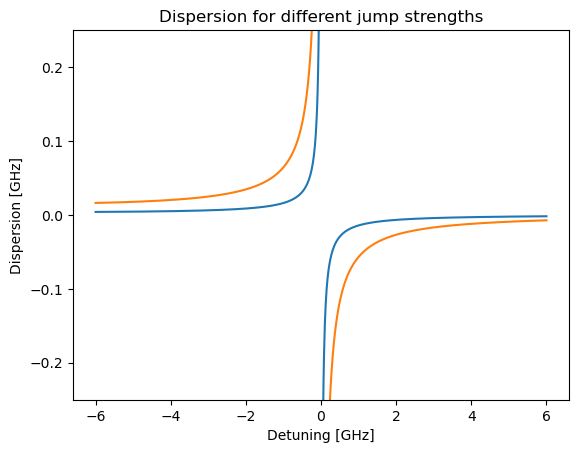

In [9]:
### Plotting the dispersive shift ### 

def dispersive_matrix(resonator_frequency, jump_matrix, jump_strength, transmon_hamiltonian):
    # Get the eigenenergies of transmon and the differences
    omegas = np.diag(transmon_hamiltonian)
    omega_diffs = omegas - np.expand_dims(omegas, axis = 1)

    # Calculate the dispersive shifts
    chi_matrix = jump_strength ** 2 * abs(jump_matrix) ** 2 * (1 / (omega_diffs + resonator_frequency) + 1 / (omega_diffs - resonator_frequency))

    return chi_matrix

def dispersive_shift(resonator_frequency, jump_matrix, jump_strength, transmon_hamiltonian):
    chi_matrix = dispersive_matrix(resonator_frequency, jump_matrix, jump_strength, transmon_hamiltonian)
    return np.sum(chi_matrix[0,:]) - np.sum(chi_matrix[1, :])

# Plot axis
detunings = np.linspace(-6, 6, 1000) * 2 * np.pi
resonator_frequencies = H_t[1, 1] - H_t[0, 0] + detunings

func_dispersive_shift = np.vectorize(lambda omega, g: dispersive_shift(omega, jump_matrix, g, H_t))

# Calculate the dispersive shift for each frequency
chis_50mhz  = func_dispersive_shift(resonator_frequencies, 0.05 * 2 * np.pi)
chis_100mhz = func_dispersive_shift(resonator_frequencies, 0.10 * 2 * np.pi)

lims = (-1, 1)
mask_50 = (chis_50mhz < lims[0]) | (chis_50mhz > lims[1])
chis_50mhz[mask_50] = np.inf

mask_100 = (chis_100mhz < lims[0]) | (chis_100mhz > lims[1])
chis_100mhz[mask_100] = np.inf

fig, ax = plt.subplots()

ax.plot(detunings / 2 / np.pi, chis_50mhz)
ax.plot(detunings / 2 / np.pi, chis_100mhz)


ax.set(
    xlabel = 'Detuning [GHz]',
    ylabel = 'Dispersion [GHz]',
    title = 'Dispersion for different jump strengths',
    ylim = (-.25, .25)
)

# E3

In [10]:
# Define the resonator to give us raising and lowering operators
detuning = - 1 * 2 * np.pi # 0.030 * 2 * np.pi / 2 # GHz 
reso = comp.Resonator(
    omega    = detuning + H_t[1, 1] - H_t[0, 0],
    n_cutoff = resonator_states
)

# This system includes partial trace and other dimension related methods
system = utils.System(dimensions = (resonator_states, computational_states))

I_res, I_transmon = system.get_identities()

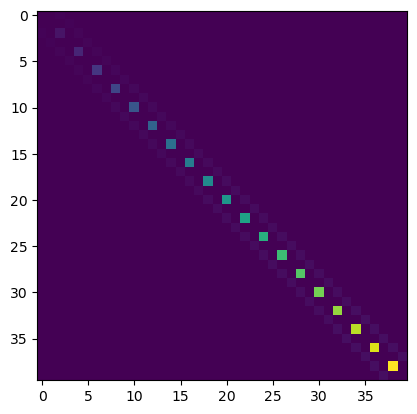

In [11]:
drive_amplitude  = 0.005  # h GHz
drive_frequency  = reso.omega - 0.015

# jump_strength    = 0.050 * 2 * np.pi # h GHz
chi              = 0.030 # h GHz # dispersive_shift(reso.omega, jump_matrix, drive_amplitude, H_t)

omega            = H_t[1, 1] - H_t[0, 0] 

sigma_z = np.diag((1, -1))

# Define the Hamiltonian
def get_hamilton(omega, drive_amplitude, drive_frequency, chi):
    H_transmon = 0 # np.kron(I_res, H_t)
    H_res      = (reso.omega - drive_frequency) * np.kron(reso.n_matrix().todense(), I_transmon)
    H_disp     = (chi / 2) * np.kron(reso.n_matrix().todense(), sigma_z)
    H_drive    = (drive_amplitude) * np.kron((reso.a().todense() + reso.a_dagger().todense()), I_transmon)

    H = H_transmon + H_res + H_disp + H_drive

    return H

H = get_hamilton(omega, drive_amplitude, drive_frequency, chi)
plt.imshow(H)

In [12]:
t = 500 # ns 

transmon_initial        = np.array([0, 1]) #/ np.sqrt(2)
resonator_initial       = np.zeros(resonator_states)
resonator_initial[0]    = 1
initial_state           = np.kron(resonator_initial, transmon_initial)

In [13]:
times = np.linspace(0, t, 101)

from scipy.linalg import expm
unitary_transformations = expm(-1j * times.reshape(-1, 1, 1) * np.array(H)) 

In [14]:
unitary_transformations.shape

(101, 40, 40)

In [15]:
psi_t = unitary_transformations @ initial_state

operator = np.kron(reso.n_matrix().todense(), I_transmon)

exp_n_reso_0 = np.array([psi_t[i, :].conj().T @ operator @ psi_t[i, :] for i in range(len(times))])

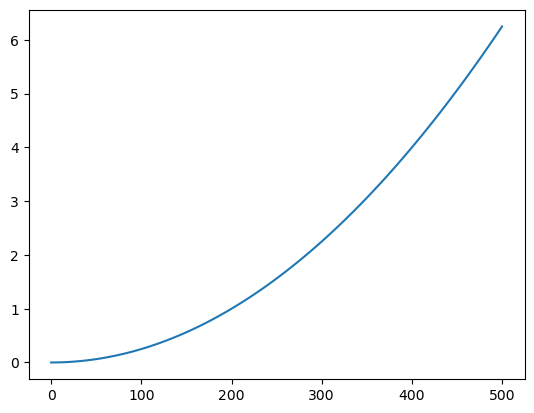

In [16]:
# from np.linalg import 
plt.plot(times, exp_n_reso_0.flatten().real)
# plt.plot(times, exp_n_reso_1.flatten().real)

In [177]:
exp_n_reso.shape

(101,)